In [1]:
import torch
import torchvision
from torch import nn
import time
import torch.nn.functional as F
from torch import optim
from einops import rearrange
from torchvision import datasets, transforms
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

import argparse
import sys
sys.argv = ['run.py']

import h5py
import copy

import numpy as np
import matplotlib.pylab as plt

In [2]:
parser = argparse.ArgumentParser(description='Cnn heisenberg')

parser.add_argument('--batch-size', type=int, default=100, metavar='N',help='input batch size for training (default: 100)')

parser.add_argument('--epochs', type=int, default=100, metavar='N',help='number of epochs to train (default: 100)')

parser.add_argument('--no-cuda', action='store_true', default=False,help='enables CUDA training')

parser.add_argument('--imgage-size', type=int, default=20,help='input image size')

parser.add_argument('--imgage-patch', type=int, default=4,help='segmentation image patch')

parser.add_argument('--channels', type=int, default=2, help='_')

parser.add_argument('--num-class', type=int, default=2,help='num class')

parser.add_argument('--mlp-dim', type=int, default=200, help='_')

parser.add_argument('--num_token',type=int, default=96, help='_')

parser.add_argument('--dropout-rate', type=int, default=0.2, help='_')

parser.add_argument('--learning-rate', type=int, default=1e-4, help='_')


args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")

In [3]:
#载入数据
data=[]
M_raw=[]

with h5py.File('four_phases_data/124_MT_20size_1T_jiangede.hdf5', 'r') as f:

    for i in np.arange(1,41):   
    
        dataset=f[str(i)+'.0K']
    
        data.append(dataset[:])

        M_raw.append(dataset[:].mean(axis=(0,2,3)).sum())

data=np.array(data)
M_raw=np.array(M_raw)
print(data.shape)

sample_num, data_num = data.shape[1], data.shape[0]

data=data.reshape(-1, args.channels, args.imgage_size, args.imgage_size)

T = np.linspace(1,40,data_num)
Tc=19

Phase_label=[]

[Phase_label.append(0) if i<=Tc else Phase_label.append(1)  for i in T for j in range(sample_num)]

# Phase_label=np.array(Phase_label)

#数据做变形,处于0到1之间,并将其和独热码转为tensor
data_set=(data+1)/2

data_set=torch.tensor(data_set).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

#整合数据与标签
data_all=[[data_set[i], Phase_label[i]] for i in range(sample_num*data_num)]

data_all_beyondTc = data_all[:5*sample_num]+data_all[35*sample_num:]
data_all_closeTc = data_all[15*sample_num:25*sample_num]


print(data_set.shape)
print(Phase_label.shape)
print(len(data_all_beyondTc), len(data_all_closeTc))



#载入数据
data=[]
M_raw_test=[]

with h5py.File('four_phases_data/124_MT_20size_2T_jiangede.hdf5', 'r') as f:

    for i in np.arange(1,41): #15,25+1  
    
        dataset=f[str(i)+'.0K']
    
        data.append(dataset[:])

        M_raw_test.append(dataset[:].mean(axis=(0,2,3)).sum())

data=np.array(data)
M_raw_test=np.array(M_raw_test)
print(data.shape)

sample_num = data.shape[1]

data_num = data.shape[0]

data=data.reshape(-1, args.channels, args.imgage_size, args.imgage_size)

T_test = np.linspace(1,40,data_num)
Tc=19

Phase_label=[]

[Phase_label.append(0) if i<=Tc else Phase_label.append(1)  for i in T_test for j in range(sample_num)]


#数据做变形,处于0到1之间,并将其和独热码转为tensor
data_set=(data+1)/2

data_set=torch.tensor(data_set).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

#整合数据与标签
data_all_test=[[data_set[i], Phase_label[i]] for i in range(sample_num*data_num)]

data_all_test_beyondTc = data_all_test[:5*sample_num]+data_all_test[35*sample_num:]
data_all_test_closeTc = data_all_test[15*sample_num:25*sample_num]

print(data_set.shape)
print(Phase_label.shape)
print(len(data_all_test_closeTc),len(data_all_test_beyondTc))


#载入数据
data=[]
M_raw_train_2=[]

with h5py.File('four_phases_data/124_MT_20size_1.5T_jiangede.hdf5', 'r') as f:

    for i in np.arange(1,41): # 15,25+1 
    
        dataset=f[str(i)+'.0K']
    
        data.append(dataset[:])

        M_raw_train_2.append(dataset[:].mean(axis=(0,2,3)).sum())

data=np.array(data)
M_raw_train_2=np.array(M_raw_train_2)
print(data.shape)

sample_num = data.shape[1]

data_num = data.shape[0]

data=data.reshape(-1, args.channels, args.imgage_size, args.imgage_size)

T_train2 = np.linspace(1,40,data_num)
Tc=19

Phase_label=[]

[Phase_label.append(0) if i<=Tc else Phase_label.append(1)  for i in T_train2 for j in range(sample_num)]


#数据做变形,处于0到1之间,并将其和独热码转为tensor
data_set=(data+1)/2

data_set=torch.tensor(data_set).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

#整合数据与标签
data_all_2=[[data_set[i], Phase_label[i]] for i in range(sample_num*data_num)]
data_all_2_beyondTc = data_all_2[:5*sample_num]+data_all_2[35*sample_num:]
data_all_2_closeTc = data_all_2[15*sample_num:25*sample_num]


print(data_set.shape)
print(Phase_label.shape)
print(len(data_all_2_beyondTc), len(data_all_2_closeTc))


(40, 500, 2, 20, 20)
torch.Size([20000, 2, 20, 20])
torch.Size([20000])
5000 5000
(40, 500, 2, 20, 20)
torch.Size([20000, 2, 20, 20])
torch.Size([20000])
5000 5000
(40, 500, 2, 20, 20)
torch.Size([20000, 2, 20, 20])
torch.Size([20000])
5000 5000


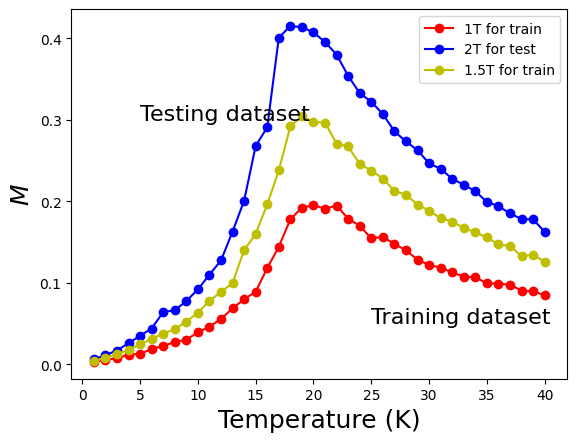

In [4]:

plt.plot(T,M_raw,'ro-',label='1T for train')

plt.plot(T_test,M_raw_test,'bo-',label='2T for test')
plt.plot(T_train2,M_raw_train_2,'yo-',label='1.5T for train')


plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel(r'$M$', fontsize=18)


plt.text(25,0.05,'Training dataset',fontsize=16)
plt.text(5,0.30,'Testing dataset',fontsize=16)


plt.legend()
plt.show()

In [5]:
class Heisenberg_dataset:
    def __init__(self, x_list):
        """ initialize the class instance
        Args:
            x_list: data with list type
        Returns:
            None
        """
        if not isinstance(x_list, list):
            raise ValueError("input x_list is not a list type")
        self.data = x_list
        print("intialize success")
    
    def __getitem__(self, idx):
        # print("__getitem__ is called")
        return self.data[idx]
    
    def __len__(self):
        # print("__len__ is called")
        return len(self.data)

data_train = Heisenberg_dataset(data_all_closeTc + data_all_2_closeTc)#+data_all_test_closeTc
data_test = Heisenberg_dataset(data_all_test)#data_all_beyondTc+data_all_2_beyondTc+


train_loader = DataLoader(data_train, batch_size = args.batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size = args.batch_size, shuffle=True )



intialize success
intialize success


In [6]:
len(test_loader)

200

In [36]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self, h_dim=500, class_num=2,dropout_rate=0.1):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.convseq = nn.Sequential(

            nn.Conv2d(args.channels, 28 , kernel_size=4, stride=2),
            nn.BatchNorm2d(28),
            nn.Dropout(p=dropout_rate),
            
            nn.LeakyReLU(),#8*8
            # nn.GELU(),

            nn.Conv2d(28, 28, kernel_size=3, stride=1 ),
            nn.BatchNorm2d(28),
            nn.Dropout(p=dropout_rate),
            nn.LeakyReLU(),#6*6
            # nn.GELU(),

            nn.Conv2d(28, 28, kernel_size=3, stride=1 ),
            nn.BatchNorm2d(28),
            nn.Dropout(p=dropout_rate),
            nn.LeakyReLU(),#6*6

            nn.Conv2d(28, 28, kernel_size=3, stride=1 ),
            nn.BatchNorm2d(28),
            nn.Dropout(p=dropout_rate),
            nn.LeakyReLU(),#6*6


        )

        self.dense = nn.Sequential(
            nn.Linear(28*3*3, h_dim),
            nn.Dropout(p=dropout_rate),

            nn.LeakyReLU(),
            # nn.ReLU(),
            # nn.LayerNorm(h_dim),
            nn.BatchNorm1d(h_dim),
            
            nn.Linear(h_dim, class_num),
            # nn.Sigmoid()
            # nn.Softmax()

        )
        
    
    
    def forward(self, inputs):
        
        outputs = self.convseq(inputs)
        outputs = outputs.view(outputs.size(0), -1)  #or use [ outputs.size(0), ]
        outputs = self.dense(outputs)
        return outputs
    

def Train_model(model, optimizer, data_loader, loss_history,epoch):
    model.train()
    total_samples = len(data_loader)*data_loader.batch_size#len(data_loader.dataset)

    The_loss=0

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        data=data.to(device)
        target=target.to(device)

        # output = F.log_softmax(model(data), dim=1)
        # loss = F.nll_loss(output, target)

        loss_f = nn.CrossEntropyLoss()
        loss = loss_f(model.forward(data), target)

        # outputs=F.gumbel_softmax(model(data), tau=5, hard=False,dim=-1)
        # outputs = torch.log(outputs)
        # loss_f = nn.NLLLoss()
        # loss = loss_f(outputs,target)

        The_loss+=loss.detach().item()

        loss.backward()
        optimizer.step()

    loss_history.append(The_loss/len(data_loader))#loss.item()

    if epoch % 10==0 or epoch<=5:
        print('Epoch {}: Average train loss : {:.5f}'.format(epoch,The_loss/len(data_loader)))

def evaluate(model, data_loader, loss_history,Accuracy_rate,epoch):
    model.eval()

    total_samples = len(data_loader)*data_loader.batch_size#len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data=data.to(device)
            target=target.to(device)
            ###
            # output = F.log_softmax(model(data), dim=1)
            # loss = F.nll_loss(output, target, reduction='sum')

            loss_f = nn.CrossEntropyLoss()
            loss = loss_f(model(data),target)

            # outputs=F.gumbel_softmax(model(data), tau=5, hard=False,dim=-1)
            # outputs = torch.log(outputs)
            # loss_f = nn.NLLLoss()
            # loss = loss_f(outputs,target)

            # _, pred = torch.max(output, dim=0)#

            total_loss += loss.item()
            # correct_samples += pred.eq(target).sum()
            ###
            output_f=nn.Softmax(dim=-1)
            predicted = output_f(model.forward(data)).argmax(dim=-1)
            # predicted=F.gumbel_softmax(model.forward(data), tau=1, hard=True,dim=-1).argmax(dim=-1)


            # total += target.size(0)
            correct_samples += predicted.eq(target).sum().item()


    avg_loss = total_loss / len(data_loader)#total_samples
    loss_history.append(avg_loss)
    Accuracy = 100.0 * correct_samples / total_samples
    Accuracy_rate.append(Accuracy)

    if epoch % 10 ==0 or epoch<=5:

        print('Epoch {}: '.format(epoch)+'Average test loss: ' + '{:.5f}'.format(avg_loss) +
            '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
            '{:5}'.format(total_samples) + ' (' +
            '{:4.2f}'.format(Accuracy) + '%)\n')



In [37]:
%%time

model_D = Discriminator( h_dim=args.mlp_dim, class_num=args.num_class,dropout_rate=0.2)#args.dropout_rate

model_D.to(device)
optimizer = optim.Adam(model_D.parameters(), lr=args.learning_rate)

train_loss_history, test_loss_history, Accuracy_rate = [], [], []
for epoch in range(1, args.epochs + 1):#1000+1
    # print('Epoch:', epoch)
    Train_model(model_D, optimizer, train_loader, train_loss_history,epoch)
    evaluate(model_D, test_loader, test_loss_history,Accuracy_rate,epoch)

Epoch 1: Average train loss : 0.60721
Epoch 1: Average test loss: 0.22816  Accuracy:18824/20000 (94.12%)

Epoch 2: Average train loss : 0.39947
Epoch 2: Average test loss: 0.15724  Accuracy:18957/20000 (94.78%)

Epoch 3: Average train loss : 0.35535
Epoch 3: Average test loss: 0.14444  Accuracy:19005/20000 (95.03%)

Epoch 4: Average train loss : 0.33532
Epoch 4: Average test loss: 0.13080  Accuracy:19032/20000 (95.16%)

Epoch 5: Average train loss : 0.32236
Epoch 5: Average test loss: 0.12667  Accuracy:19047/20000 (95.23%)

Epoch 10: Average train loss : 0.28350
Epoch 10: Average test loss: 0.10978  Accuracy:19057/20000 (95.28%)

Epoch 20: Average train loss : 0.23807
Epoch 20: Average test loss: 0.09575  Accuracy:19133/20000 (95.67%)

Epoch 30: Average train loss : 0.19932
Epoch 30: Average test loss: 0.09130  Accuracy:19174/20000 (95.87%)

Epoch 40: Average train loss : 0.17794
Epoch 40: Average test loss: 0.09630  Accuracy:19149/20000 (95.75%)

Epoch 50: Average train loss : 0.15527

In [24]:
# model_D

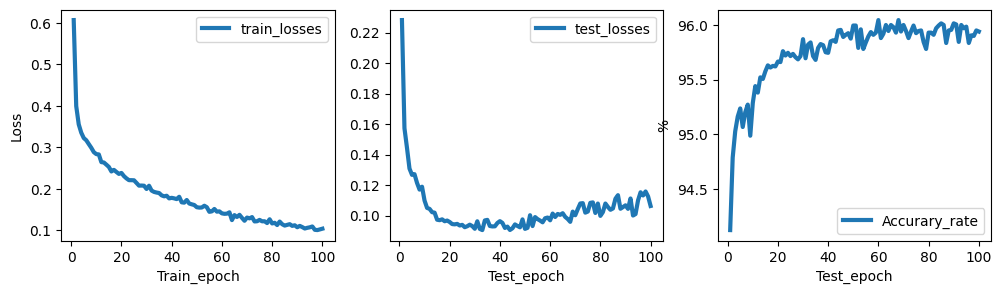

In [38]:
fig=plt.figure(figsize=(12,3))

ax1=plt.subplot(131)
ax1.plot(np.arange(1,len(train_loss_history)+1),train_loss_history, linewidth=3, linestyle='-', label='train_losses')
ax1.set_xlabel('Train_epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2=plt.subplot(132)
ax2.plot(np.arange(1,len(test_loss_history)+1),test_loss_history, linewidth=3, linestyle='-', label='test_losses')
ax2.set_xlabel('Test_epoch')
ax2.legend()


ax3=plt.subplot(133)
ax3.plot(np.arange(1,len(Accuracy_rate)+1),Accuracy_rate, linewidth=3, linestyle='-', label='Accurary_rate')
ax3.set_xlabel('Test_epoch')
ax3.set_ylabel('%')
ax3.legend()

plt.show()

In [39]:
T_test = np.linspace(1,40,data_num)
output_label = np.zeros(len(T_test))
model_D.eval()
for i in range(0,sample_num*len(T_test), sample_num):
    A_test=data_all_test[i:i+500]
    label_all=0
    with torch.no_grad():
        for img ,label in A_test:
            img=img.cuda()
            img=img.view(-1,args.channels,args.imgage_size,args.imgage_size)
            A=nn.Softmax(dim=-1)(model_D(img)).argmax(dim=-1)
            label_all+=A
            # print(A)
        print('{} K The number of PM by model is {}'.format((int(i/500+1)), label_all.cpu().numpy()))
        output_label[(int(i/500))] = label_all.cpu().numpy()/sample_num


1 K The number of PM by model is [0]
2 K The number of PM by model is [0]
3 K The number of PM by model is [0]
4 K The number of PM by model is [0]
5 K The number of PM by model is [0]
6 K The number of PM by model is [0]
7 K The number of PM by model is [0]
8 K The number of PM by model is [0]
9 K The number of PM by model is [0]
10 K The number of PM by model is [0]
11 K The number of PM by model is [0]
12 K The number of PM by model is [0]
13 K The number of PM by model is [0]
14 K The number of PM by model is [0]
15 K The number of PM by model is [0]
16 K The number of PM by model is [0]
17 K The number of PM by model is [47]
18 K The number of PM by model is [216]
19 K The number of PM by model is [312]
20 K The number of PM by model is [381]
21 K The number of PM by model is [448]
22 K The number of PM by model is [473]
23 K The number of PM by model is [485]
24 K The number of PM by model is [481]
25 K The number of PM by model is [498]
26 K The number of PM by model is [499]
27

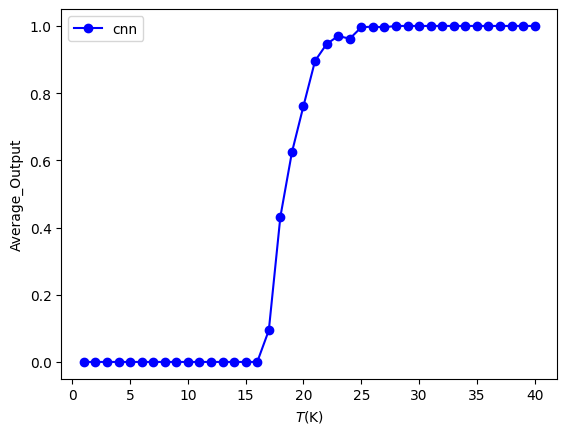

In [40]:
plt.plot(T_test,output_label, 'bo-',label='cnn')
plt.ylabel('Average_Output')
plt.xlabel(r'$T$(K)')
plt.legend()
plt.show()

In [46]:
T_test1=18
i=np.random.randint((T_test1-1)*500, T_test1*500)
print(i)
img, label=data_all_test[i]
print(label)
img=img.view(-1,2,20,20).to(device)
# nn.Softmax(dim=-1)(model_D(img))
F.gumbel_softmax(model_D(img), tau=5, hard=False)

8607
tensor(0)


tensor([[0.4817, 0.5183]], device='cuda:0', grad_fn=<SoftmaxBackward0>)